In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

imdb = load_dataset('/content/drive/My Drive/Colab/Uni/HS23/EITASP/', data_files={'train': 'train_binary.csv', 'test': 'test_binary.csv', 'validation': 'validation_binary.csv'})
# tokenized_imdb = imdb.map(preprocess_function, batched=True)

In [8]:
imdb['train'][0]

{'Unnamed: 0.1': 1893,
 'Unnamed: 0': 1893,
 '_id': '5c34e1c593ac7c001ca22f47',
 'review': 'Sehr gute Vorlesung - sehr unfaire Prüfung....',
 'score': 3,
 'upvotes': 11.0,
 'downvotes': 2.0,
 'sum': 1}

In [9]:
imdb = imdb.rename_column("review", "text")
imdb = imdb.rename_column("sum", "labels")

In [10]:
imdb = imdb.remove_columns(["Unnamed: 0", "_id", "score", "upvotes", "downvotes"])

In [11]:
imdb

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'text', 'labels'],
        num_rows: 6826
    })
    test: Dataset({
        features: ['Unnamed: 0.1', 'text', 'labels'],
        num_rows: 1897
    })
    validation: Dataset({
        features: ['Unnamed: 0.1', 'text', 'labels'],
        num_rows: 759
    })
})

In [ ]:
!pip install seaborn
!pip install matplotlib

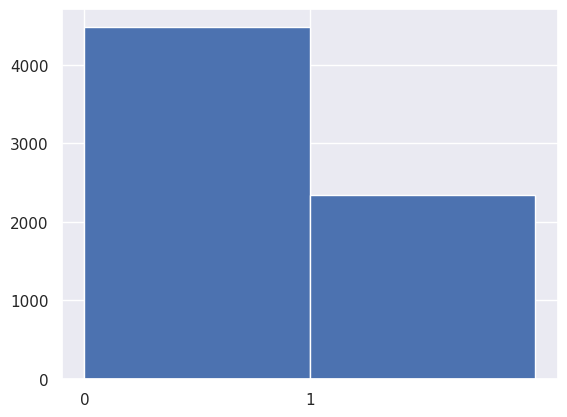

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.rcParams['font.size'] = 10
plt.hist(imdb["train"]["labels"], bins=[0, 1, 2]);
plt.xticks(range(0, 2))

plt.show()

In [ ]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-german-cased", padding=True, trunctuation=True)

In [17]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

In [19]:
input_ids = tokenized_imdb['train']['input_ids']
attention_mask = tokenized_imdb['train']['attention_mask']
labels = tokenized_imdb['train']['labels']

In [ ]:
import numpy as np

X = np.column_stack((input_ids, attention_mask))  # Stack them horizontally
y = np.array(labels)
X[0]

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy={0: 2500})
X_res, y_res = rus.fit_resample(X, y)
X_res[0]

In [ ]:
input_ids_resampled = X_res[:, :len(input_ids[0])]
attention_mask_resampled = X_res[:, :len(input_ids[0])]
attention_mask_resampled[0]

In [23]:
# De-nest the resampled lists
input_ids_resampled = [list(arr[0]) for arr in input_ids_resampled]
attention_mask_resampled = [list(arr[0]) for arr in attention_mask_resampled]


In [24]:
from datasets import Dataset

dataset_resampled = Dataset.from_dict({
    'input_ids': input_ids_resampled,
    'attention_mask': attention_mask_resampled,
    'labels': y_res,
    'text': ['' for _ in range(len(y_res))]
})


In [25]:
input_ids_resampled_list = [list(arr) for arr in input_ids_resampled]
attention_mask_resampled_list = [list(arr) for arr in attention_mask_resampled]
print(type(input_ids_resampled_list), type(input_ids_resampled_list[0]))  # should both be <class 'list'>
print(len(input_ids_resampled_list), len(input_ids_resampled_list[0]))  # should match your dataset's dimensions



<class 'list'> <class 'list'>
4839 20


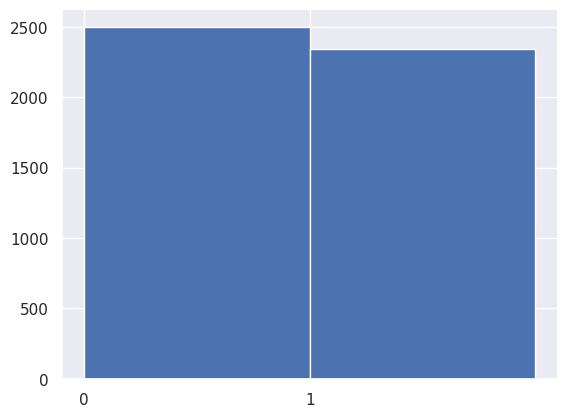

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.rcParams['font.size'] = 10
plt.hist(dataset_resampled["labels"], bins=[0, 1, 2]);
plt.xticks(range(0, 2))

plt.show()

In [27]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
!pip install evaluate

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [30]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [31]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(dataset_resampled["labels"]), y=imdb["train"]["labels"])
class_wts

array([0.76064185, 1.45917059])

In [ ]:
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-german-cased", num_labels=2
)

In [33]:
import torch
import torch.nn as nn

In [34]:
# Check if GPU is available
if torch.cuda.is_available():
    print("using GPU")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

using GPU


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
torch.tensor(weights)

# loss function
# cross_entropy  = nn.NLLLoss(weight=weights)

In [36]:
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [50]:
training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/Colab/Uni/HS23/EITASP/trial3_weighted",
    learning_rate=1e-5,  # Adjusted learning rate
    per_device_train_batch_size=4,  # Smaller train batch size
    per_device_eval_batch_size=4,  # Smaller eval batch size
    num_train_epochs=3,  # More epochs
    weight_decay=0.01,  # Added weight decay for regularization
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_resampled,
    eval_dataset=tokenized_imdb["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.014300,5.036777,0.536232
2,0.042900,4.569799,0.555995
3,0.053500,4.420432,0.542819


TrainOutput(global_step=3630, training_loss=0.033145418311610365, metrics={'train_runtime': 244.3647, 'train_samples_per_second': 59.407, 'train_steps_per_second': 14.855, 'total_flos': 311289331453020.0, 'train_loss': 0.033145418311610365, 'epoch': 3.0})